In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [2]:
training_df = pd.read_csv('../../data/training_df.csv')
valid_df = pd.read_csv('../../data/our_valid.csv')

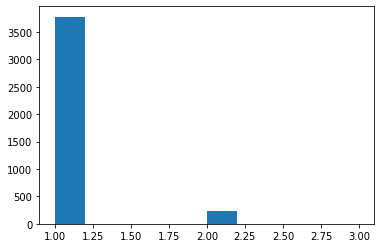

In [117]:
keypoints_per_arg = [x[1] for x in training_df[training_df.label == 1].arg_id.value_counts().to_dict().items()]
plt.hist(keypoints_per_arg)
plt.show()

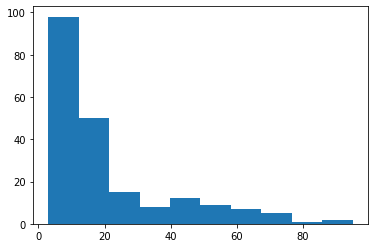

In [118]:
args_per_keypoints = [x[1] for x in training_df[training_df.label == 1].key_point_id.value_counts().to_dict().items()]
plt.hist(args_per_keypoints)
plt.show()

-------------

### Predicting:

In [4]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

sys.path.insert(0, "../../src-py")

In [5]:
from track_1_kp_matching import *

In [6]:
from sentence_transformers import SentenceTransformer, InputExample, LoggingHandler, losses, models, util

In [7]:
valid_df = pd.read_csv('../../data/our_valid.csv', index_col=0)
valid_keypoints_df = pd.read_csv('../../data/key_points_our_valid.csv')
valid_arguments_df = pd.read_csv('../../data/arguments_our_valid.csv')

In [8]:
def match_argument_with_keypoints(result, kp_dict, arg_dict):
    
    for arg, arg_embedding in arg_dict.items():
        result[arg] = {}
        for kp, kp_embedding in kp_dict.items():
            result[arg][kp] = util.pytorch_cos_sim(arg_embedding, kp_embedding).item()
    
    return result

def predict(model, argument_df, keypoint_df, output_path, append_topic=False):
    argument_keypoints = {}
    for topic in argument_df.topic.unique():
        for stance in [-1, 1]:
            topic_keypoints_ids = keypoint_df[(keypoint_df.topic==topic) & (keypoint_df.stance==stance)]['key_point_id'].tolist()
            topic_keypoints = keypoint_df[(keypoint_df.topic==topic) & (keypoint_df.stance==stance)]['key_point'].tolist()
            if append_topic:
                topic_keypoints = [topic + ' <SEP> ' + x for x in topic_keypoints]
                
            topic_keypoints_embeddings = model.encode(topic_keypoints)
            topic_kp_embed = dict(zip(topic_keypoints_ids, topic_keypoints_embeddings))

            topic_arguments_ids = argument_df[(argument_df.topic==topic) & (argument_df.stance==stance)]['arg_id'].tolist()
            topic_arguments = argument_df[(argument_df.topic==topic) & (argument_df.stance==stance)]['argument'].tolist()
            topic_arguments_embeddings = model.encode(topic_arguments)
            topic_arg_embed= dict(zip(topic_arguments_ids, topic_arguments_embeddings))

            argument_keypoints = match_argument_with_keypoints(argument_keypoints, topic_kp_embed, topic_arg_embed)
    
    json.dump(argument_keypoints, open(output_path, 'w'))
    
    return argument_keypoints

In [46]:
models_list = [
    '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/bert-base-uncased-kp_as_anchor_topic_added-2021-05-24_13-52-11',
    '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/bert-base-uncased-kp_as_anchor-2021-05-24_15-58-35/',
    #'/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/all-triplet-loss',
    #'/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/hard-softmargin-triplet-loss',
    #'/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/hard-triplet-loss',
    #'/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss',
]

pred_output_path = '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/preds/'
subset_name= 'our_valid'

In [47]:
def predict_and_evaluate(argument_df, keypoint_df, gold_data_dir, subset_name):
    pred_df = {}
    for model_path in models_list:
        append_topic= 'topic_added' in model_path
        #Predict
        model = SentenceTransformer(model_path)
        model_name = model_path.split('/')[-1]
        predictions_file = pred_output_path+model_name+ '-' + subset_name + '-preds.json'
        json_preds = predict(model, argument_df, keypoint_df, predictions_file, append_topic)

        #Evaluate
        arg_df, kp_df, labels_df = load_kpm_data(gold_data_dir, subset=subset_name)
        merged_df = get_predictions(predictions_file, labels_df, arg_df)
        print('Evaluating {}:'.format(model_name))
        evaluate_predictions(merged_df)
        
        pred_df[model_name] = merged_df

    return pred_df

In [48]:
pred_dfs = predict_and_evaluate(valid_arguments_df, valid_keypoints_df,  '../../data', 'our_valid')

Evaluating bert-base-uncased-kp_as_anchor_topic_added-2021-05-24_13-52-11:
mAP strict= 0.8100212009895027 ; mAP relaxed = 0.9253012513042258
Evaluating :
mAP strict= 0.844355603203168 ; mAP relaxed = 0.947050810808719


In [49]:
test_df = pd.read_csv('../../data/our_test.csv', index_col=0)
test_keypoints_df = pd.read_csv('../../data/key_points_our_test.csv')
test_arguments_df = pd.read_csv('../../data/arguments_our_test.csv')

In [50]:
_=predict_and_evaluate(test_arguments_df, test_keypoints_df,  '../../data', 'our_test')

Evaluating bert-base-uncased-kp_as_anchor_topic_added-2021-05-24_13-52-11:
mAP strict= 0.8452575961620323 ; mAP relaxed = 0.9603199729435812
Evaluating :
mAP strict= 0.8884606072596714 ; mAP relaxed = 0.963442996320446


In [51]:
all_valid_arg_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/arguments_dev.csv')
all_valid_keypoints_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/key_points_dev.csv')
results_df = predict_and_evaluate(all_valid_arg_df, all_valid_keypoints_df, '../../KPA_2021_shared_task/kpm_data/', 'dev')

Evaluating bert-base-uncased-kp_as_anchor_topic_added-2021-05-24_13-52-11:
mAP strict= 0.80786323253463 ; mAP relaxed = 0.9322304651486044
Evaluating :
mAP strict= 0.854248407787326 ; mAP relaxed = 0.9531621481387572
